# Performances of matrix multiplication

In the following, we plot the time taken to do a matrix multiplication with different numbers of processors.
We use the outer product algorithm.

**Warning:** in all this notebook, loglog scale are used for nearly all plots.

In [1]:
library(ggplot2)
local_results <- read.csv("results_local.csv")
global_results <- read.csv("results_global.csv")

plot_results <- function(global_results, local_results, matrix_size, comment=""){

    local_subresults <- local_results[local_results["matrix_size"] == matrix_size,]
    global_subresults <- global_results[global_results["matrix_size"] == matrix_size,]
    communication_times <- local_subresults[,c("nb_proc", "communication_time")]
    colnames(communication_times) <- c("nb_proc", "time")
    communication_times$group <- "communication"
    computation_times <- local_subresults[,c("nb_proc", "computation_time")]
    colnames(computation_times) <- c("nb_proc", "time")
    computation_times$group <- "computation"
    global_times <- global_subresults[,c("nb_proc", "time")]
    global_times$group <- "total"

    all_times = rbind(communication_times, computation_times, global_times)
    
    title <- paste("Time to perform a matrix product\nMatrices of size", matrix_size, "\n", comment)
    return(ggplot(all_times, aes(x=nb_proc, y=time, group=group, col=group, fill=group))+
        scale_x_log10()+ scale_y_log10()+
        stat_summary(geom="ribbon", fun.data=mean_cl_normal)+
        stat_summary(geom="line", fun.y=mean)+
        stat_summary(geom="point", fun.y=mean)+
        ggtitle(title)
    )
}

All started with this plot, which has a strange  shape.

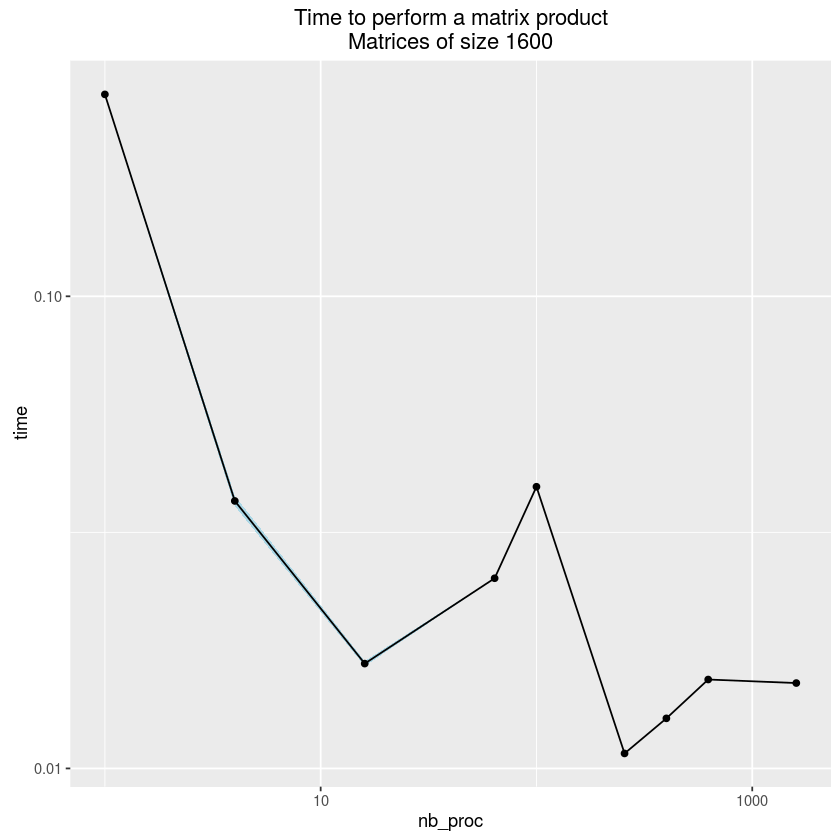

In [2]:
subresults <- global_results[global_results["matrix_size"] == 1600,]
ggplot(subresults, aes(x=nb_proc, y=time))+
    scale_x_log10()+ scale_y_log10()+
    stat_summary(geom="ribbon", fun.data=mean_cl_normal, fill="lightblue")+
    stat_summary(geom="line", fun.y=mean)+
    stat_summary(geom="point", fun.y=mean)+
    ggtitle("Time to perform a matrix product\nMatrices of size 1600")

Let's see where this time is spent.

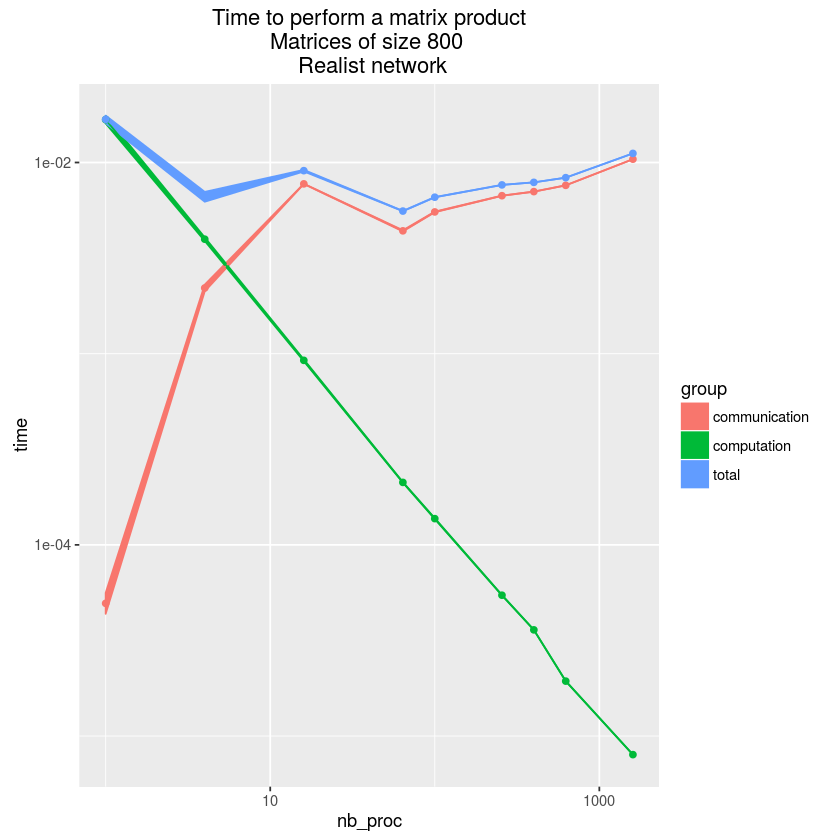

In [3]:
plot_results(global_results, local_results, 800, "Realist network")

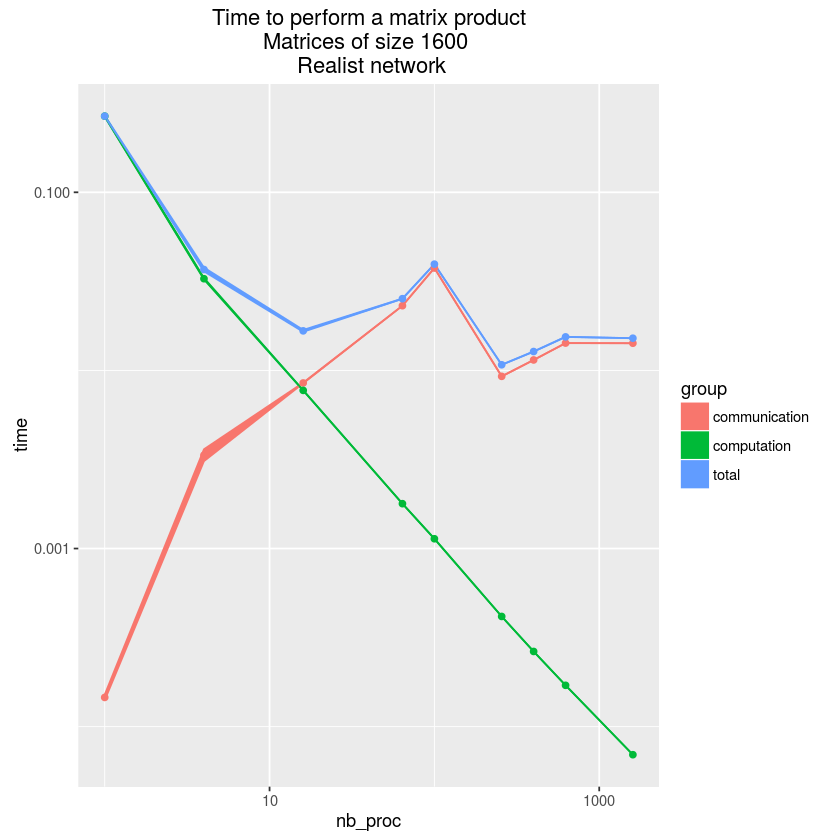

In [4]:
plot_results(global_results, local_results, 1600, "Realist network")

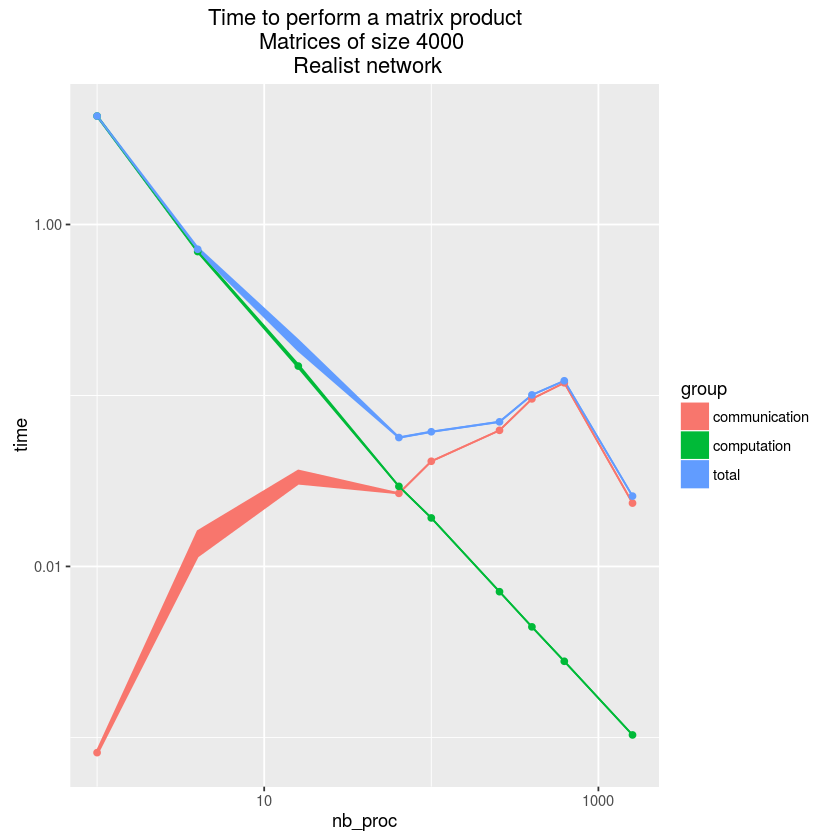

In [5]:
plot_results(global_results, local_results, 4000, "Realist network")

Very strange. The plots of the total time firstly decrease, then increase and then decrease a second time.

Adding processors make them handle smaller matrices and all these second-decreases happen when the processors have sub-matrices of about the same size:
```python
800**2/64
# 10000
1200**2/100
# 14400.0
1600**2/256
# 10000
2000**2/256
# 15625.0
4000**2/1600
# 10000
```

The plots clearly show that this behavior come from the communication time and not the computation time. Maybe this is due to a different behavior of MPI_Bcast for “small” messages and “big” messages?

Let us see what happens with a “perfect network” (i.e. no latency and absurdly high bandwidth).

In [6]:
global_results_perfect <- read.csv("results_perfect_network_global.csv")
local_results_perfect <- read.csv("results_perfect_network_local.csv")

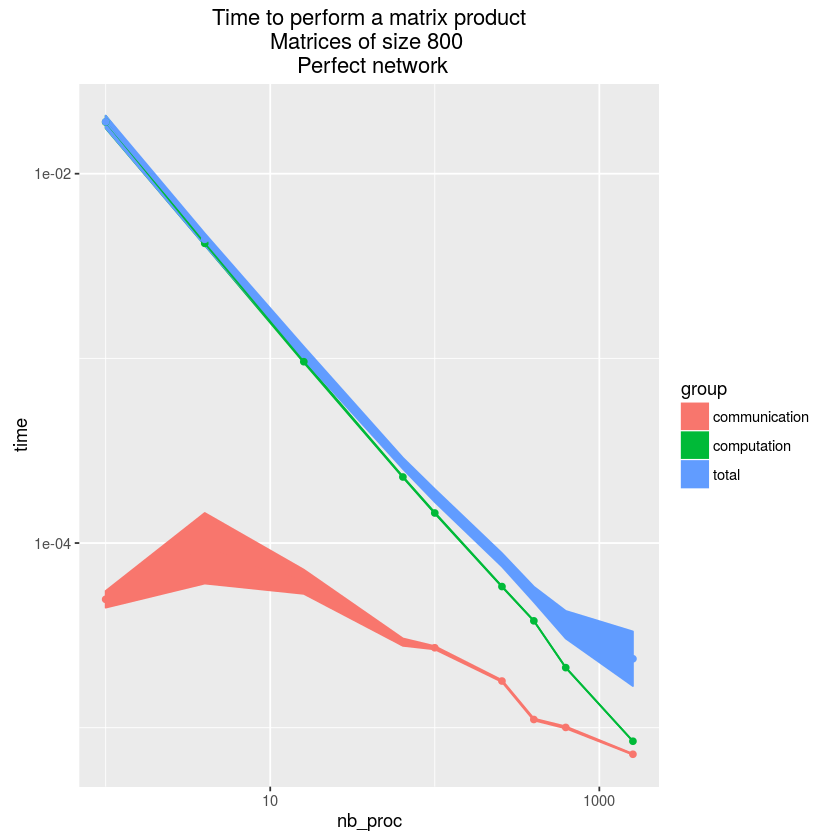

In [7]:
plot_results(global_results_perfect, local_results_perfect, 800, "Perfect network")

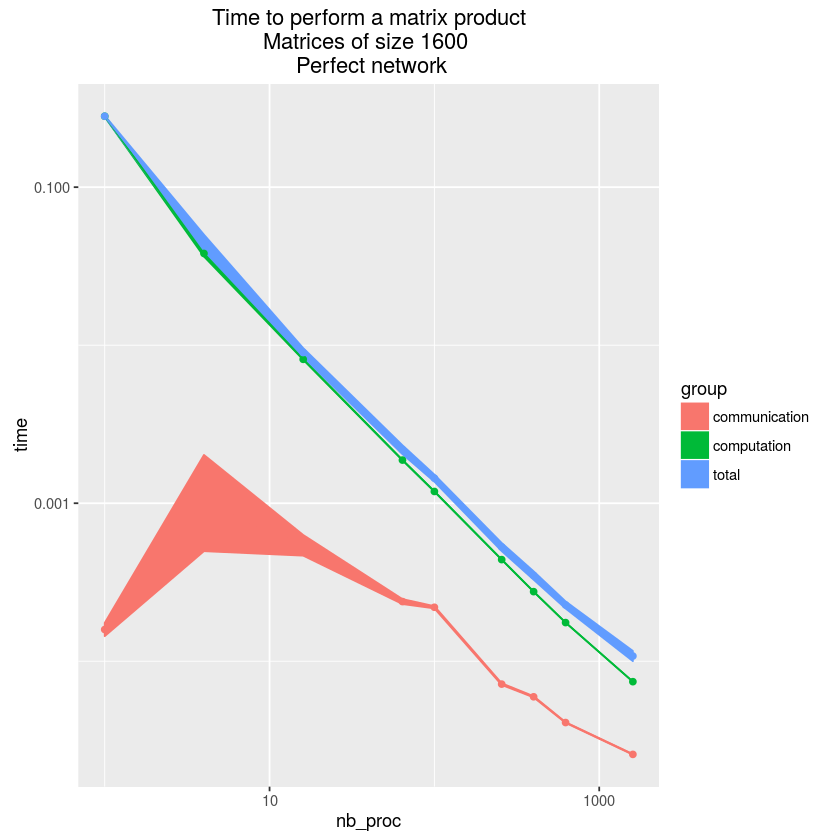

In [8]:
plot_results(global_results_perfect, local_results_perfect, 1600, "Perfect network")

More expected plot here. However, the fact that communication time is not constant is strange.

Cluster was:
```xml
<?xml version='1.0'?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">
<platform version="4">
<AS id="AS0" routing="Full">
<cluster id="cluster" prefix="host-" suffix=".hawaii.edu" radical="0-1599" speed="200Gf" bw="1000000Gbps" lat="0"/>
</AS>
</platform>
```

# Performances of broadcast

The above plots have shown that something strange happens regarding the communication time when the sub-matrices have around 10000 elements.

In our implementation of the matrix product, broadcasts are made with the whole sub-matrix. We therefore expect something strange happening with the broadcast performances for a message of approximately 10000 floats.

In [9]:
broadcast_results <- read.csv("results_broadcast.csv")

plot_broadcast <- function(results, nb_proc, x_dashed=-1, comment=""){
    subresults <- results[results["nb_proc"] == nb_proc,]
    title <- paste("Time to broadcast a message with", nb_proc, "processors\nMessage size is given in number of floats\n", comment)
    p <- ggplot(subresults, aes(x=msg_size, y=time))+
        scale_x_log10()+ scale_y_log10()+
        stat_summary(geom="ribbon", fun.data=mean_cl_normal, fill="lightblue")+
        stat_summary(geom="line", fun.y=mean)+
        stat_summary(geom="point", fun.y=mean)+
        ggtitle(title)
    if(x_dashed > 0) {
        p <- p + geom_vline(xintercept=x_dashed,linetype="dashed", colour="red")+
        annotate("text", x = x_dashed, y = 0.005, label = paste(x_dashed, "floats (~", round(x_dashed*4/1024), "kB)"))
    }
    return(p)
}

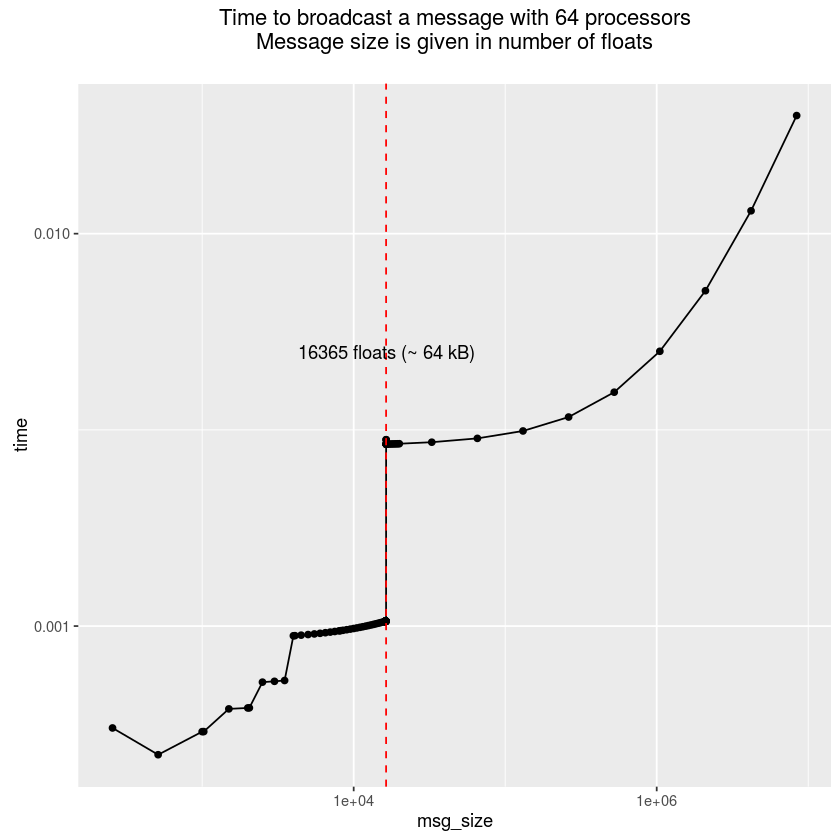

In [10]:
plot_broadcast(broadcast_results, 64, 16365)

The previous plot shows that the behavior of the multicast change for messages of about 16365 floats, i.e. 64kB. The time needed to do the broadcast is suddenly multiplied by nearly 3.

Therefore, this would explain the observation made on the matrix product plots. When we increase the number of processors, the size of the sub-matrices decreases. When these sub-matrices contain less than 16635 floats, broadcasts become suddenly much faster.

**TODO:**
    - Try a different broadcast implementation.
    - Try another topology.
    - Try another matrix product implementation (maybe a finer grain).

# Let's try another broadcast algorithm

All the following results have been obtained with the option `--cfg=smpi/bcast:mpich`. Note that in the previous sections, the default broadcast was used.

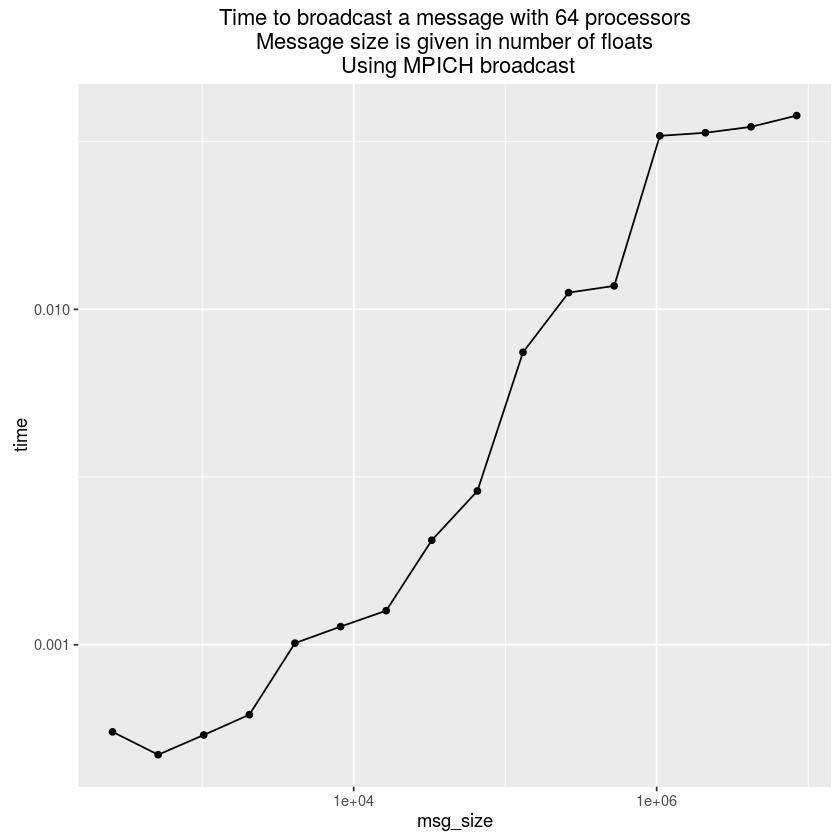

In [11]:
broadcast_results_mpich <- read.csv("results_broadcast_mpich.csv")
plot_broadcast(broadcast_results_mpich, 64, -1, "Using MPICH broadcast")

This looks more homogeneous. There are still irregularities, but they seem to be less brutal.

Let's see if we still have the strange performance behavior for the matrix product.

In [12]:
local_results_mpich <- read.csv("results_mpich_local.csv")
global_results_mpich <- read.csv("results_mpich_global.csv")

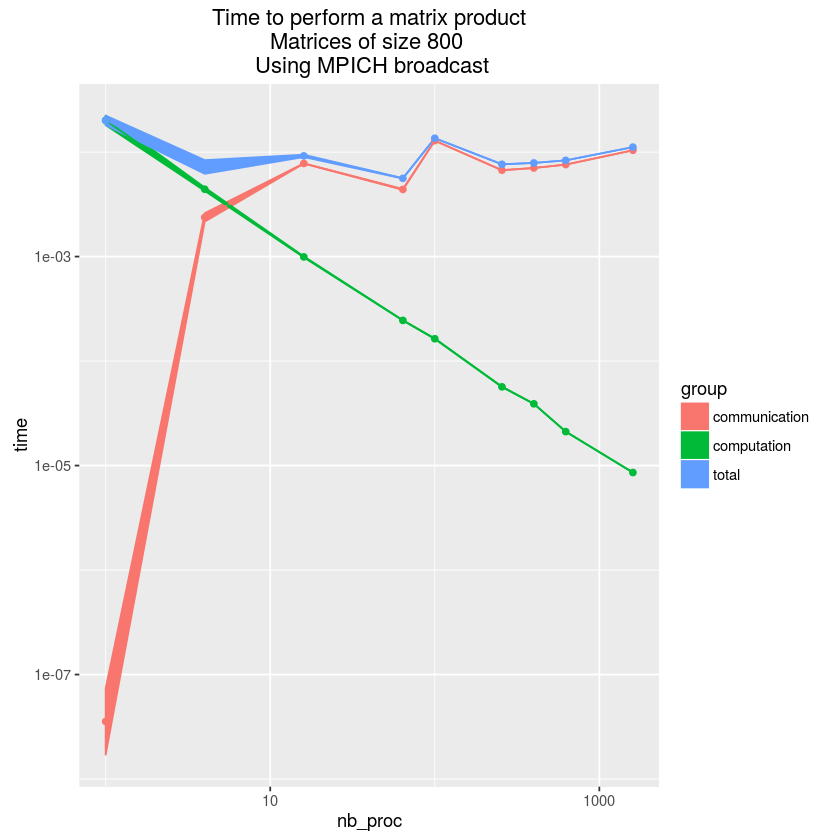

In [13]:
plot_results(global_results_mpich, local_results_mpich, 800, "Using MPICH broadcast")

Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

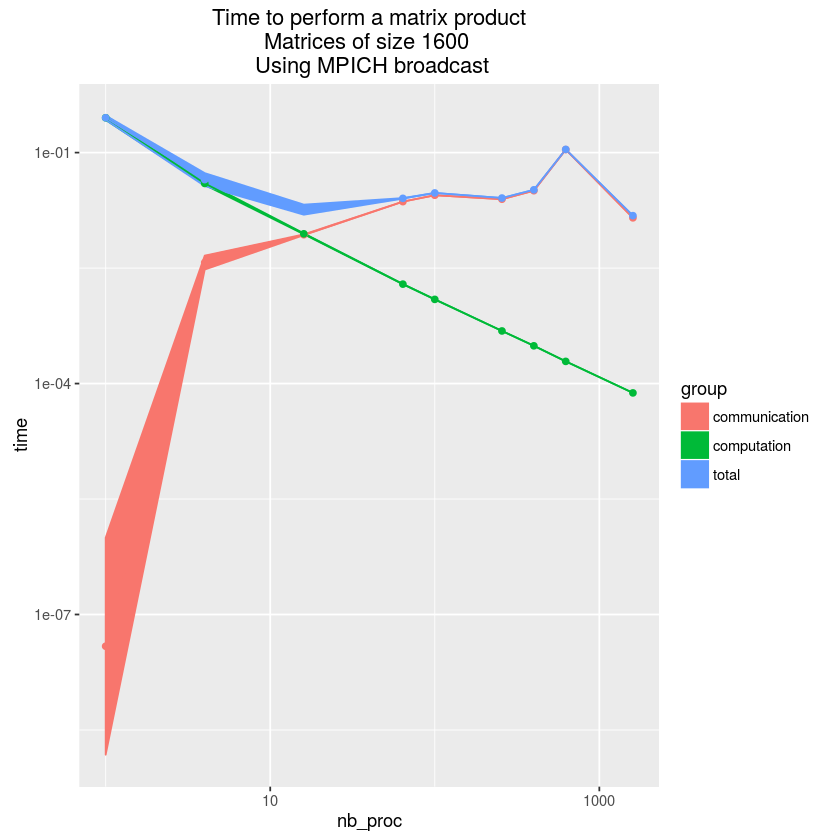

In [14]:
plot_results(global_results_mpich, local_results_mpich, 1600, "Using MPICH broadcast")

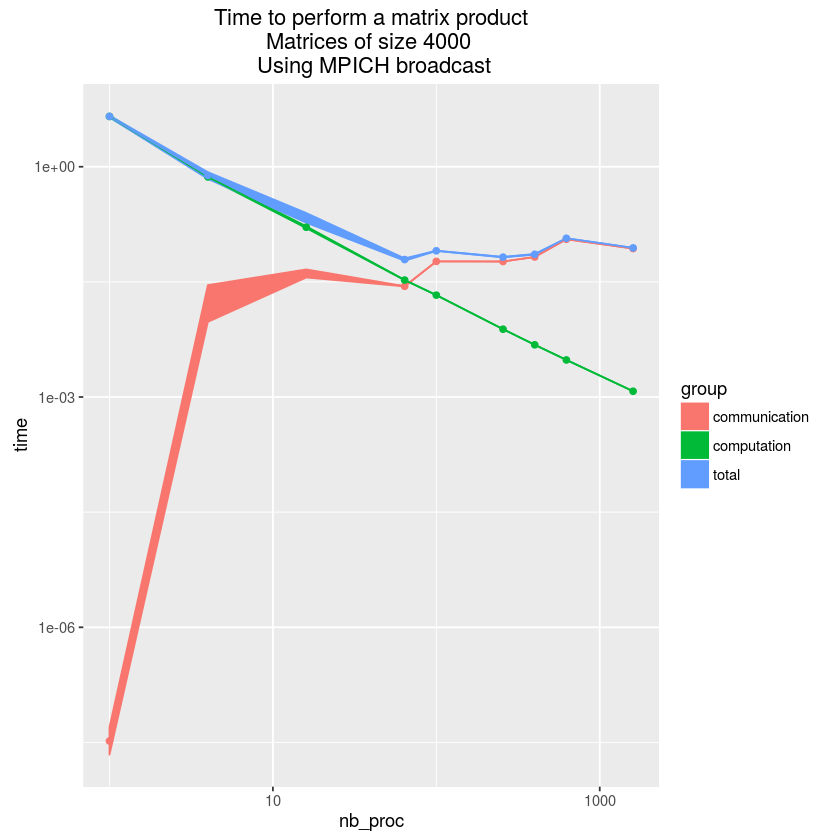

In [15]:
plot_results(global_results_mpich, local_results_mpich, 4000, "Using MPICH broadcast")

Again, we observe a strange behavior in the performances, due to the communication time. But this not the same than before.

**TODO:**
    - Try other algorithms (see http://simgrid.gforge.inria.fr/simgrid/3.13.90/doc/group__SMPI__API.html).
    - Get some information on these algorithms.

# Yet another broadcast algorithm

All the following results have been obtained with the option `--cfg=smpi/bcast:ompi`.

First remark: simulations are very slow with this algorithm (for the other algorithms, memory was the limiting factor for the simulations, for this one, time is the limiting factor).

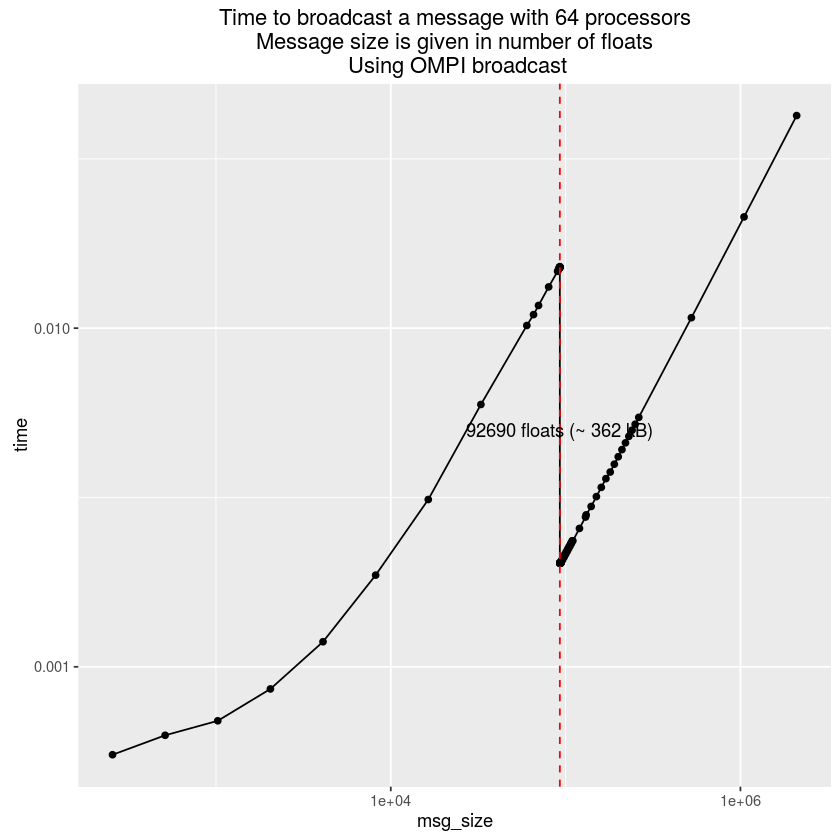

In [16]:
broadcast_results_ompi <- read.csv("results_broadcast_ompi.csv")
plot_broadcast(broadcast_results_ompi, 64, 92690, "Using OMPI broadcast")

There is a huge drop in communication time at approximately 92690 floats. The broadcast becomes suddenly more than 7 times faster.

Therefore, we expect the performances of the matrix product to suddenly decrease when the number of processors increase. This should arrive when they handle submatrices of 92690 elements, i.e. of size 304.
This should happen when the number of processors reaches 16 for the matrix of size 1600 and 256 for the matrix of size 4000.

In [17]:
local_results_ompi <- read.csv("results_ompi_local.csv")
global_results_ompi <- read.csv("results_ompi_global.csv")

Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

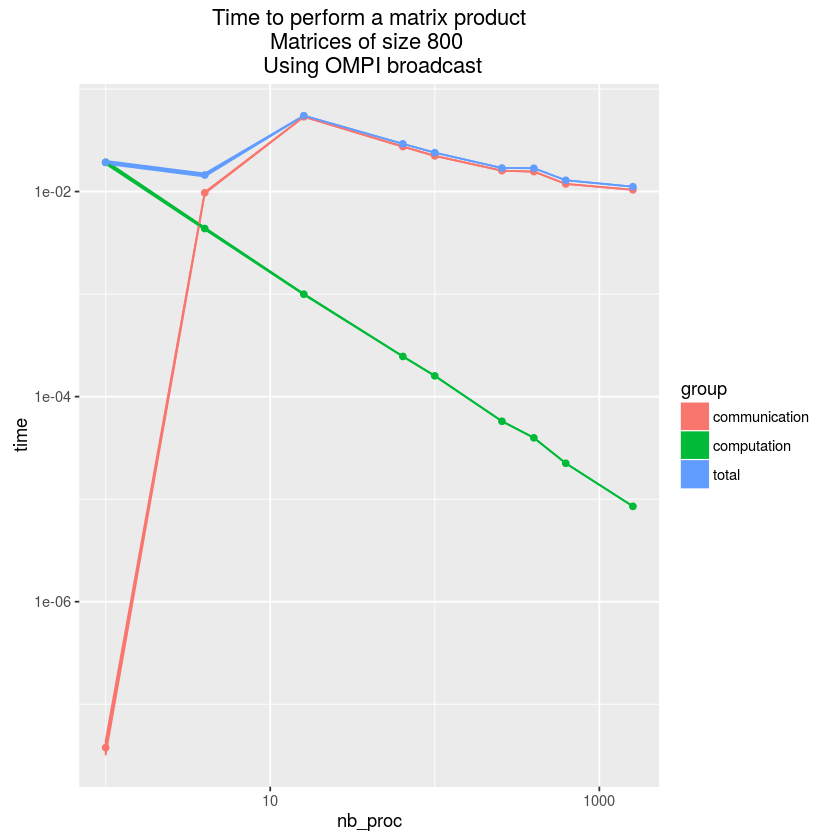

In [18]:
plot_results(global_results_ompi, local_results_ompi, 800, "Using OMPI broadcast")

Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

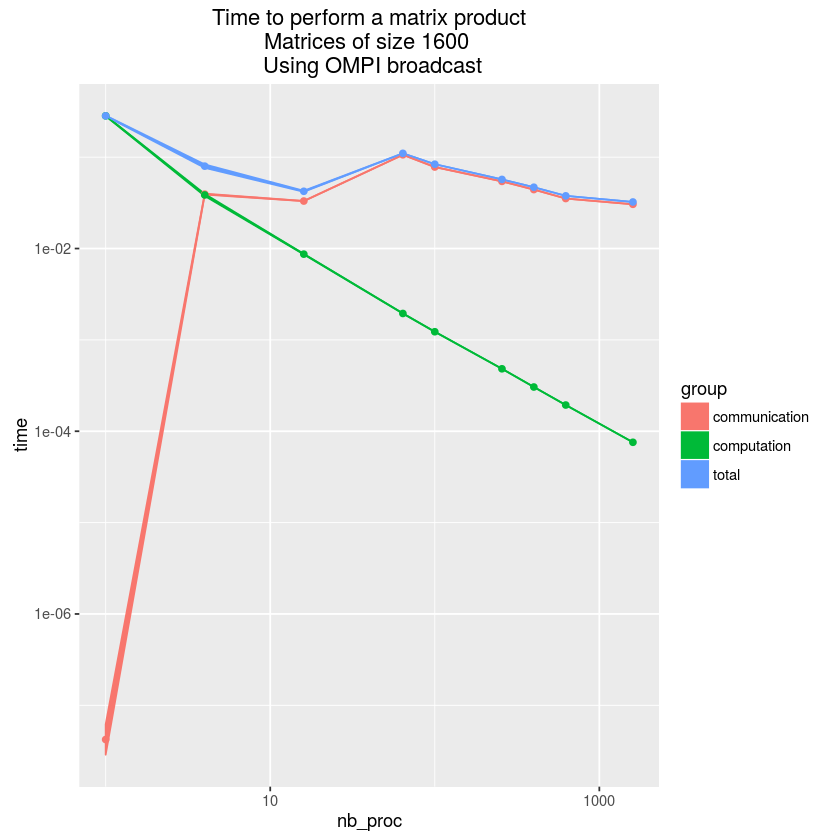

In [19]:
plot_results(global_results_ompi, local_results_ompi, 1600, "Using OMPI broadcast")

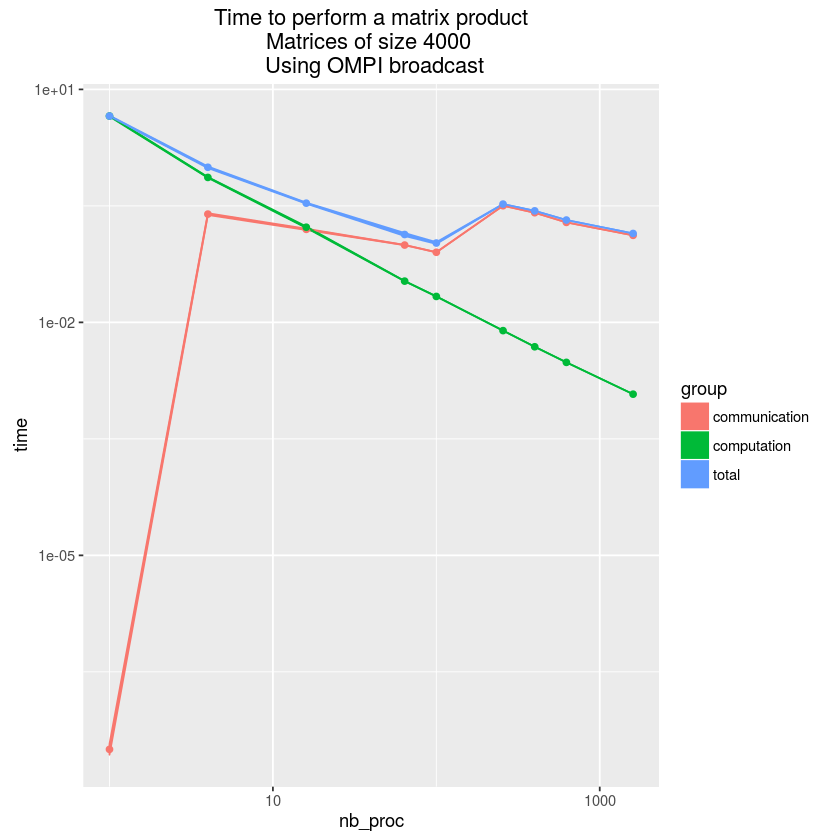

In [20]:
plot_results(global_results_ompi, local_results_ompi, 4000, "Using OMPI broadcast")

As expected, we observe that the performances of the matrix product decrease starting from 16 processors for the matrix of size 1600 and 256 processors for the matrix of size 4000.

# Comparison of the algorithms

In this section, we firstly compare the different broadcast algorithms. This should give us an idea of the performances of the matrix product algorithm when depending on the broadcast.

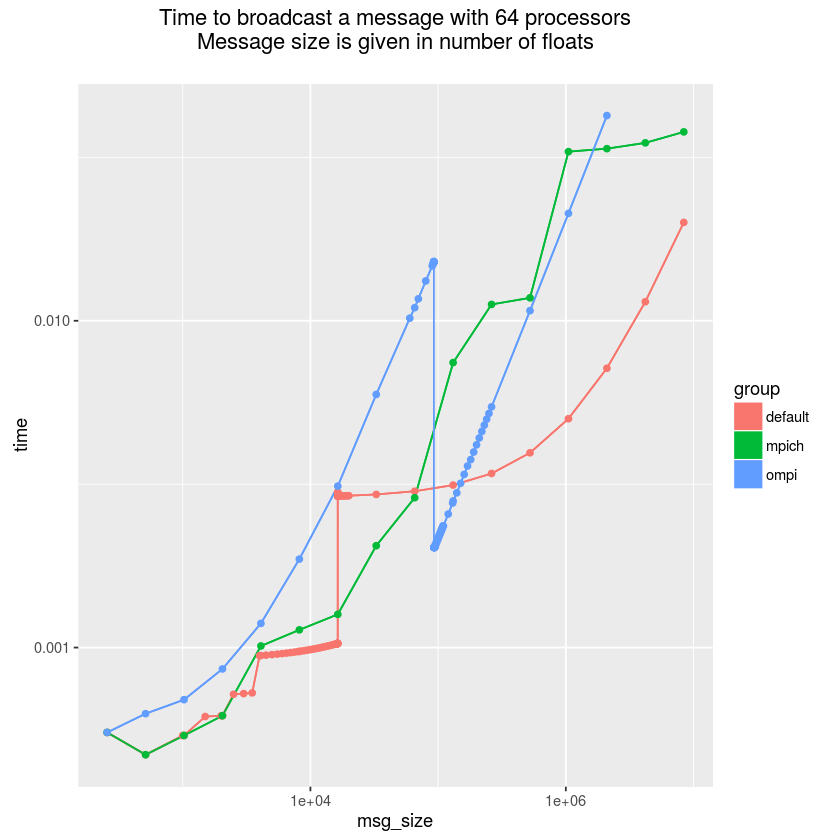

In [21]:
default_subresults <- broadcast_results[broadcast_results["nb_proc"] == 64,]
mpich_subresults <- broadcast_results_mpich[broadcast_results_mpich["nb_proc"] == 64,]
ompi_subresults <- broadcast_results_ompi[broadcast_results_ompi["nb_proc"] == 64,]

default_subresults$group <- "default"
mpich_subresults$group <- "mpich"
ompi_subresults$group <- "ompi"

all_bcast = rbind(default_subresults, mpich_subresults, ompi_subresults)

title <- paste("Time to broadcast a message with 64 processors\nMessage size is given in number of floats\n")
ggplot(all_bcast, aes(x=msg_size, y=time, group=group, col=group, fill=group))+
    scale_x_log10()+ scale_y_log10()+
    stat_summary(geom="ribbon", fun.data=mean_cl_normal)+
    stat_summary(geom="line", fun.y=mean)+
    stat_summary(geom="point", fun.y=mean)+
    ggtitle(title)

To sum up this plot, for large messages (larger than 131072 floats) the default algorithm is the clear winner.

For smaller messages, each of the three algorithms is the best at some point.

Therefore, for the largest matrices, we may observe an advantage when the default algorithm is used for a small enough number of processes (100 processors or less for the matrix of size 4000). However, do keep in mind that for a too small number of processors, the communication time is negligible in comparison with the computation time, and thus the effect of the broadcast algorithm should not be noticeable in these cases.

In [22]:
plot_all_results <- function(matrix_size){
    default_matrixresults <- global_results[global_results["matrix_size"] == matrix_size,]
    mpich_matrixresults <- global_results_mpich[global_results_mpich["matrix_size"] == matrix_size,]
    ompi_matrixresults <- global_results_ompi[global_results_ompi["matrix_size"] == matrix_size,]

    default_matrixresults$group <- "default"
    mpich_matrixresults$group <- "mpich"
    ompi_matrixresults$group <- "ompi"

    all_products = rbind(default_matrixresults, mpich_matrixresults, ompi_matrixresults)

    title <- paste("Time to perform a matrix product\nMatrices of size", matrix_size)
    return (ggplot(all_products, aes(x=nb_proc, y=time, group=group, col=group, fill=group))+
        scale_x_log10()+ scale_y_log10()+
        stat_summary(geom="ribbon", fun.data=mean_cl_normal)+
        stat_summary(geom="line", fun.y=mean)+
        stat_summary(geom="point", fun.y=mean)+
        ggtitle(title))
}

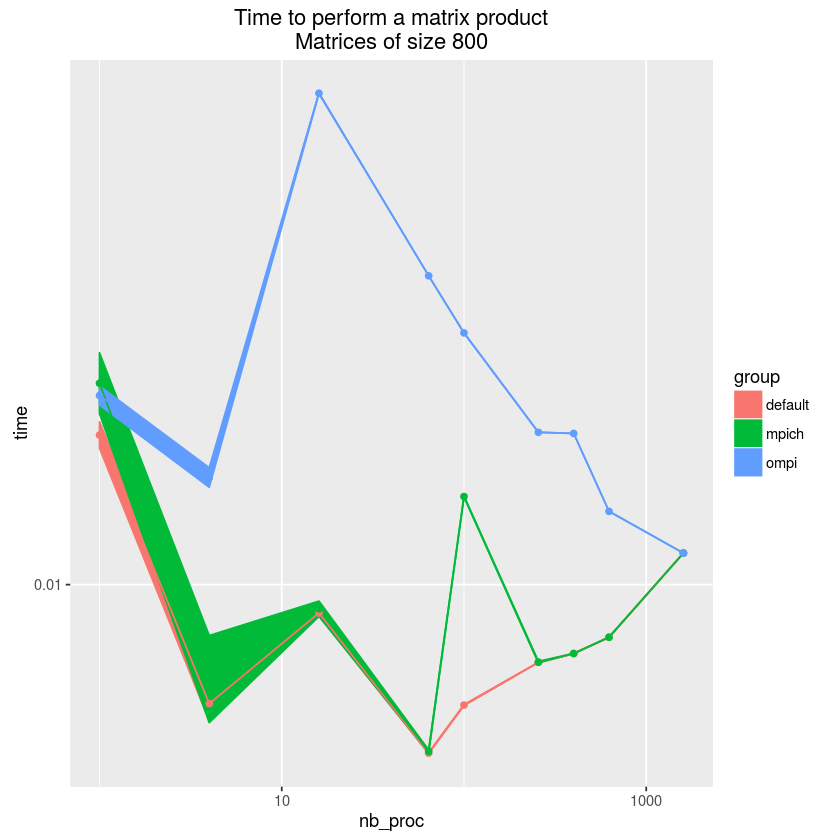

In [23]:
plot_all_results(800)

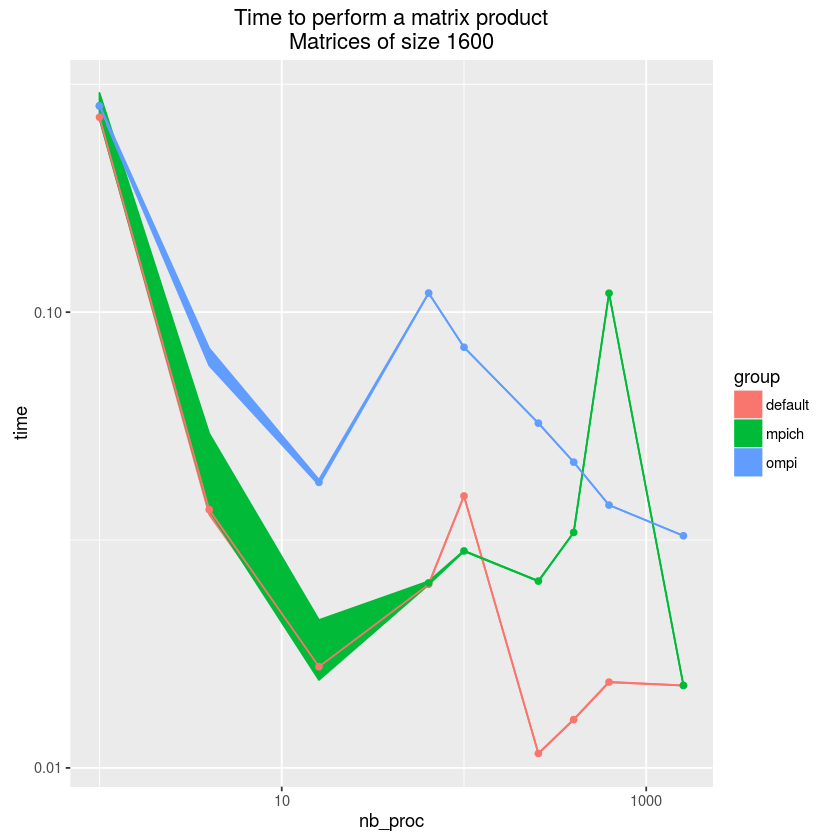

In [24]:
plot_all_results(1600)

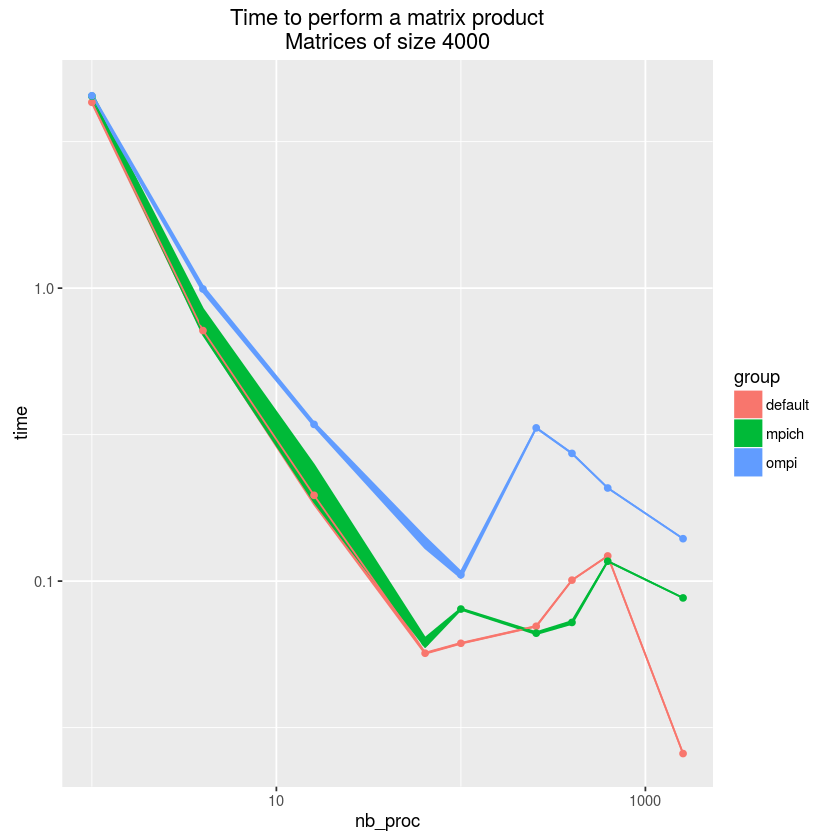

In [25]:
plot_all_results(4000)

The plots show that, depending on the parameters (matrix size and number of processors), using one broadcast implementation or another can lead to an important performance gap. Please note however that these differences are amplified by the loglog scale here.

For instance, for a matrix of size 4000 and 256 processors, using the OMPI broadcast gives a time nearly fives times larger than using the default broadcast.

Even worse, for a fixed matrix size, the best number of processors to use depends on the chosen broadcast implementation. For instance, with a matrix of size 4000, it is better to use 64 processors with the MPICH broadcast, 100 processors with the OMPI broadcast and 1600 processors with the default broadcast.

Finally, the OMPI broadcast very significantly yields the worst performances here. For a low enough number of processors, the MPICH broadcast and the default broadcast are similar, but for a larger number of processors significant differences are observed, without a clear winner.

In [26]:
reg <- lm(data=broadcast_results, time~msg_size)
summary(reg)


Call:
lm(formula = time ~ msg_size, data = broadcast_results)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0039375 -0.0005603 -0.0002581  0.0007099  0.0027013 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.215e-03  2.576e-05   47.15   <2e-16 ***
msg_size    1.917e-09  2.517e-11   76.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0008953 on 1253 degrees of freedom
Multiple R-squared:  0.8223,	Adjusted R-squared:  0.8222 
F-statistic:  5799 on 1 and 1253 DF,  p-value: < 2.2e-16


In [27]:
reg_mpich <- lm(data=broadcast_results_mpich, time~msg_size)
summary(reg_mpich)


Call:
lm(formula = time ~ msg_size, data = broadcast_results_mpich)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.019091 -0.003841 -0.003182  0.002605  0.024906 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.390e-03  5.976e-04   7.345 4.01e-12 ***
msg_size    3.455e-09  2.614e-10  13.217  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.008049 on 219 degrees of freedom
Multiple R-squared:  0.4437,	Adjusted R-squared:  0.4412 
F-statistic: 174.7 on 1 and 219 DF,  p-value: < 2.2e-16


In [28]:
reg_ompi <- lm(data=broadcast_results_ompi, time~msg_size)
summary(reg_ompi)


Call:
lm(formula = time ~ msg_size, data = broadcast_results_ompi)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0108478 -0.0032107 -0.0017707 -0.0000224  0.0178681 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.663e-03  2.350e-04   7.074 3.65e-12 ***
msg_size    2.264e-08  5.852e-10  38.684  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.005531 on 700 degrees of freedom
Multiple R-squared:  0.6813,	Adjusted R-squared:  0.6809 
F-statistic:  1496 on 1 and 700 DF,  p-value: < 2.2e-16


## TODO

* To know precisely where were the "anomalies", we did a lot of measures close to them. This biases the linear regression, the size of the messages should be taken at random.
* We should try to do this experiment not simulated, i.e. outside of simgrid. But can we observe interesting things with 2 our 4 cores?
* Doing the regression for a fixed number of processors should yield a higher R-squared (we remove “unexplained variability”).
* We should also use some randomization for the size of the messages.
* We could also have a look at the time in function of the number of processors. It should  be linear when the algorithm is a pipeline, and logarithmic when it is a tree.
* Maybe restrict ourselves to some size intervals? Because the broadcast algorithm changes depending on the size of the payload, it does not make a lot of sense to do a linear regression on the whole range.

In [49]:
results <- broadcast_results_mpich[broadcast_results_mpich["nb_proc"]==64,]
reg <- lm(data=results, time~msg_size)
summary(reg)


Call:
lm(formula = time ~ msg_size, data = results)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.011985 -0.005204 -0.004285  0.003190  0.021605 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.812e-03  9.062e-04   6.414 3.84e-09 ***
msg_size    5.246e-09  3.985e-10  13.164  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.008629 on 108 degrees of freedom
Multiple R-squared:  0.6161,	Adjusted R-squared:  0.6125 
F-statistic: 173.3 on 1 and 108 DF,  p-value: < 2.2e-16


In [50]:
xv <- seq(1000, 8388608, 1000)

In [51]:
yv <- predict(reg,list(msg_size=xv))

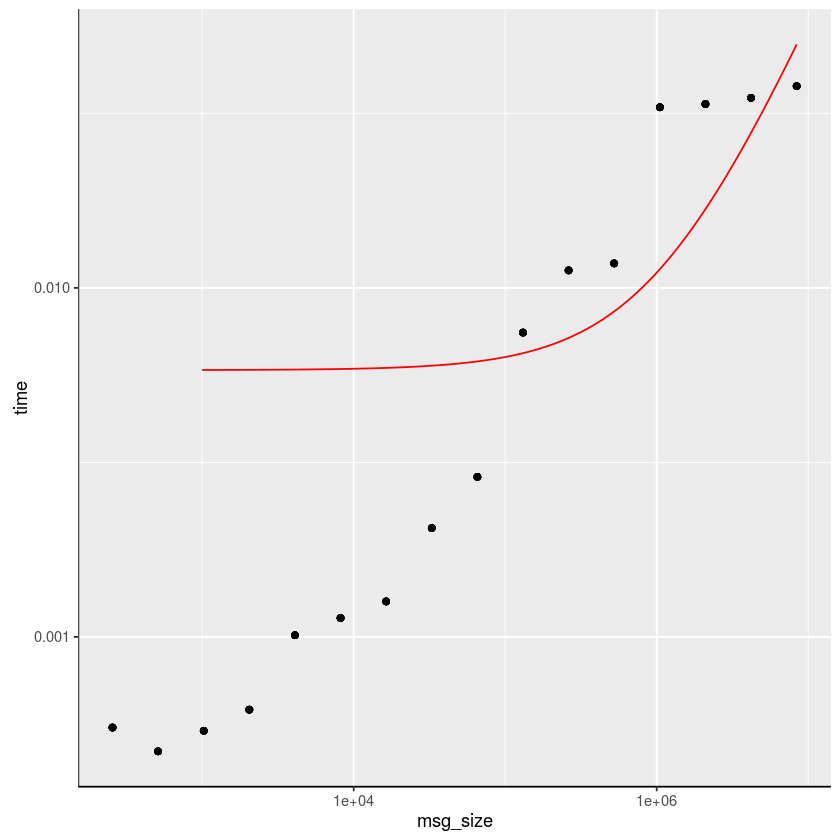

In [52]:
ggplot(data=results, aes(x=msg_size,y=time)) +
    scale_x_log10()+ scale_y_log10()+
    geom_hline(yintercept=0) + geom_vline(xintercept=0) +
    geom_point(aes(x=msg_size,y=time)) +
    geom_line(data=data.frame(x=xv,y=yv),aes(x=x,y=y),color="red")

## OMPI, large messages

In [72]:
results <- broadcast_results_ompi[broadcast_results_ompi["nb_proc"]==64 & broadcast_results_ompi["msg_size"] > 92690,]
reg <- lm(data=results, time~msg_size)
summary(reg)


Call:
lm(formula = time ~ msg_size, data = results)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.961e-05 -1.025e-05  2.834e-06  7.639e-06  1.776e-05 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.480e-04  9.161e-07   161.6   <2e-16 ***
msg_size    2.017e-08  1.780e-12 11335.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.122e-05 on 210 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.285e+08 on 1 and 210 DF,  p-value: < 2.2e-16


In [73]:
xv <- seq(92600, 2097152, 1000)
yv <- predict(reg,list(msg_size=xv))

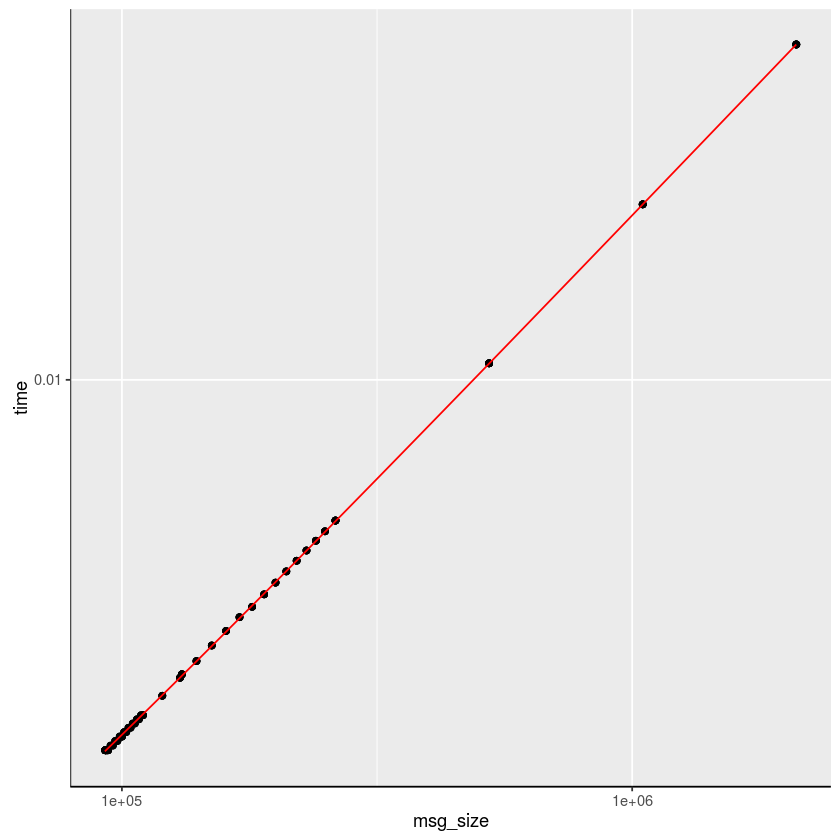

In [75]:
ggplot(data=results, aes(x=msg_size,y=time)) +
    scale_x_log10()+ scale_y_log10()+
    geom_hline(yintercept=0) + geom_vline(xintercept=0) +
    geom_point(aes(x=msg_size,y=time)) +
    geom_line(data=data.frame(x=xv,y=yv),aes(x=x,y=y),color="red")

## OMPI, small messages

In [82]:
results <- broadcast_results_ompi[broadcast_results_ompi["nb_proc"]==64 & broadcast_results_ompi["msg_size"] < 92690,]
reg <- lm(data=results, time~msg_size)
summary(reg)


Call:
lm(formula = time ~ msg_size, data = results)

Residuals:
       Min         1Q     Median         3Q        Max 
-7.793e-05 -4.821e-05 -2.717e-05  7.614e-06  2.136e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.641e-04  9.233e-06    61.1   <2e-16 ***
msg_size    1.579e-07  1.634e-10   966.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.427e-05 on 135 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 9.34e+05 on 1 and 135 DF,  p-value: < 2.2e-16


In [83]:
xv <- seq(1, 93000, 1000)
yv <- predict(reg,list(msg_size=xv))

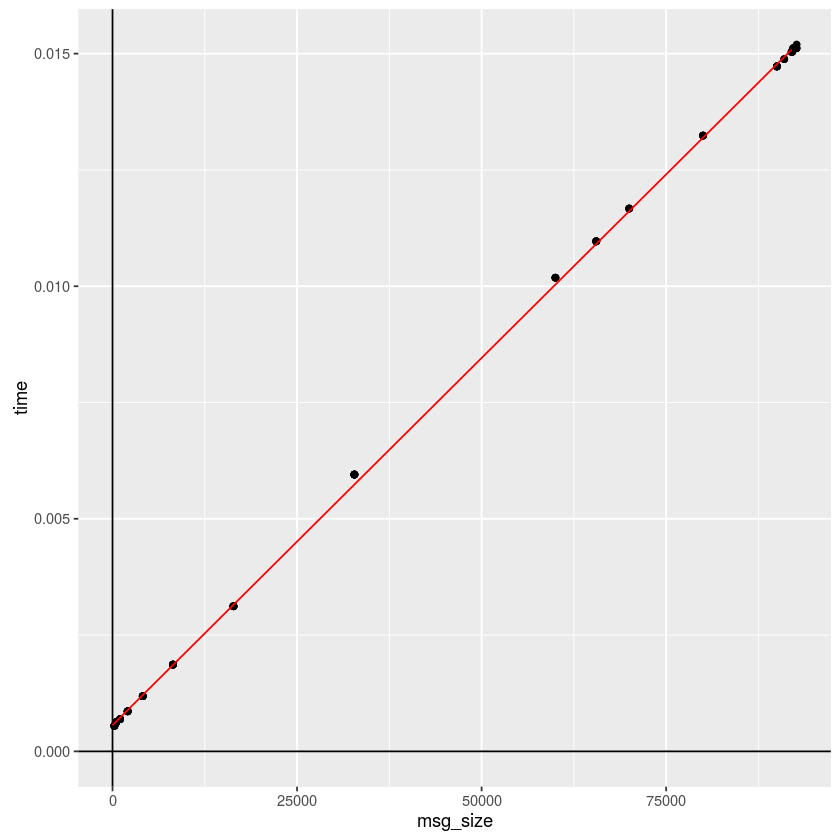

In [86]:
ggplot(data=results, aes(x=msg_size,y=time)) +
    geom_hline(yintercept=0) + geom_vline(xintercept=0) +
    geom_point(aes(x=msg_size,y=time)) +
    geom_line(data=data.frame(x=xv,y=yv),aes(x=x,y=y),color="red")

# OMPI, all messages

In [87]:
results <- broadcast_results_ompi[broadcast_results_ompi["nb_proc"]==64,]
reg <- lm(data=results, time~msg_size)
summary(reg)


Call:
lm(formula = time ~ msg_size, data = results)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0025811 -0.0025378 -0.0022841 -0.0002112  0.0106147 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.903e-03  2.662e-04   10.90   <2e-16 ***
msg_size    1.813e-08  6.619e-10   27.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004422 on 348 degrees of freedom
Multiple R-squared:  0.6831,	Adjusted R-squared:  0.6822 
F-statistic:   750 on 1 and 348 DF,  p-value: < 2.2e-16


In [88]:
xv <- seq(1, 2097152, 1000)
yv <- predict(reg,list(msg_size=xv))

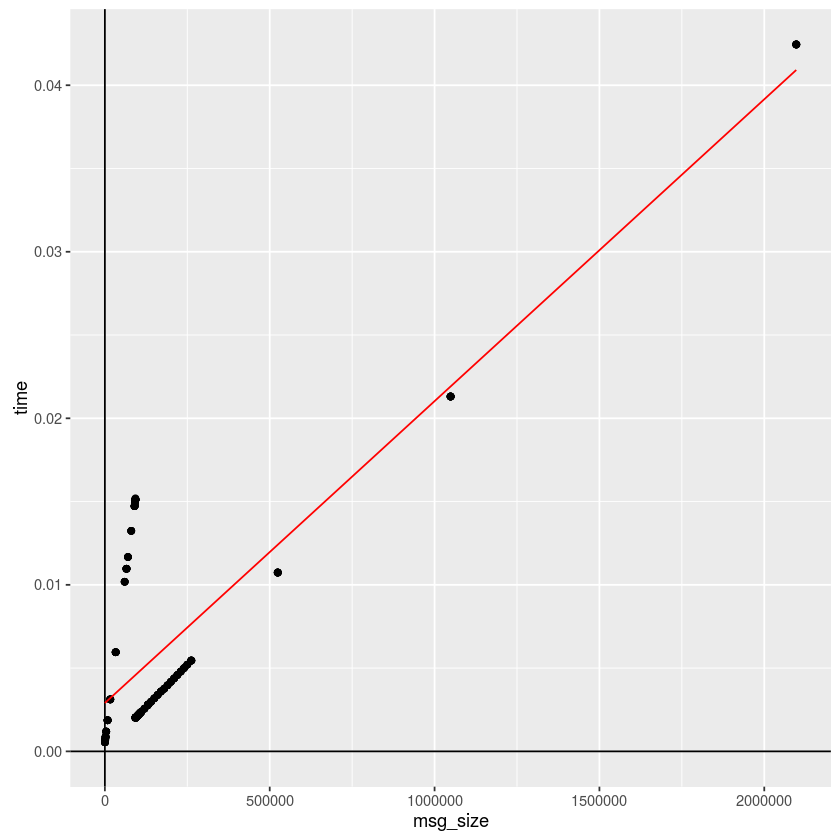

In [89]:
ggplot(data=results, aes(x=msg_size,y=time)) +
  #  scale_x_log10()+ scale_y_log10()+
    geom_hline(yintercept=0) + geom_vline(xintercept=0) +
    geom_point(aes(x=msg_size,y=time)) +
    geom_line(data=data.frame(x=xv,y=yv),aes(x=x,y=y),color="red")

## Remarks:

We clearly see from the plot that OMPI behavior can be split into two parts: “small” messages and “large” messages.

Applying statistics techniques to the whole data while keeping our simple model (i.e. time linear in the size of the message) does not work well, because this model is simply incorrect. We get a bad R-squared and a bad prediction ability, as demonstrated by the plot.

Restricting ourselves to the intervals which seem to have similar behavior (graphical observation) yields much better results. We get very high R-squared (1 and 0.9999), and the plot match closely to the points.